Let's build an NLP model to make reading medical abstracts easier by classifying sentences which appear in sequential order. The paper we are replicating (including the source of the dataset) is available here: https://arxiv.org/abs/1710.06071


The model architecture that the author used to achieve the best results is available here: https://arxiv.org/pdf/1612.05251.pdf

## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ee0bd87b-a960-e76e-6cf8-2c9a0940a6ef)


## Get data
Download the PubMed 200k RCT dataset. The authors of the paper have made the data used for the research publicly available and for free on their github page. 

Let's copy them to our local directory.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.87 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


According to the README file from the GitHub page, 

* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).
* Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.



## We will be starting our experiments on a the PubMed20k subset so that we can quickly prototype what works and what doesn't work.

In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [5]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

## Exploratory data analysis and data preprocessing

 
> We will also need to convert the data into tensors for model training.

In [6]:
# Create function to read lines of document

def get_lines(filename):
  """Reads file name and returns lines of text as a list.
  
  args:
    Filename (str): Filename containing target filepath
  
  returns:
    A list of strings with one string per line from target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [7]:
# Read in training lines
train_lines = get_lines(data_dir + '/train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Each abstract starts with a numerical ID prefaced by '###'. This can be used for separation between abstracts. Though there are >200k lines, not all of these lines are important - some are just numerical IDs of abstracts. It's also important to notice that the lines are also sequential.

Also, each sentence of the abstract has a label at the start and is tab separated from the label.

Text files do not have any structure, making deep learning difficult. A good data structure to organize our data is a list of dictionaries:

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity.\n',
    'total_lines': 11},
  ...]
  ```

In [9]:
def preprocess_text(filename):
  """
  Returns a list of dictionaries of line data from the abstract string.

  The function takes in filename, reads its contents and sorts through
  each line, extracting things like the target label, the text of sentence,
  how many sentences are in the current abstract, and what sentence the target
  line is at.
  """
  input_lines = get_lines(filename)
  abstract_lines, abstract_samples = "", []

  #Loop through list of lines and inspect each line in list.
  for line in input_lines:

    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" #reset to empty strings if line is an ID line

    #We save abstract lines into a single string. The space denotes the end
    #of the line. So we can split the string when we see a space.
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines()

      #Iterate through each line in a single abstract and count them
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #Create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') #split target label from text
        line_data['line_number'] = abstract_line_number
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()        
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else: #the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text(data_dir+'/train.txt')
val_samples = preprocess_text(data_dir+'/dev.txt')
test_samples = preprocess_text(data_dir+'/test.txt')
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 700 ms, sys: 111 ms, total: 811 ms
Wall time: 1.51 s


In [11]:
#Check the first abstract of training data
train_samples[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Transform data from a list of dictionaries to a dataframe

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [13]:
# Check distibrution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

There's some class imbalance but this is still ok 😶

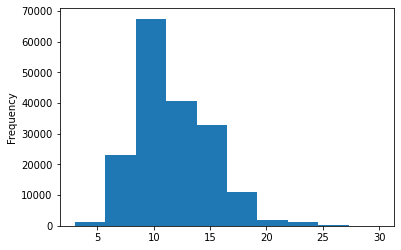

In [14]:
train_df.total_lines.plot.hist();

Quick check: Most abstracts are not very long

Extracting just the texts

In [15]:
# Convert abstract text lines into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

Make numeric labels - because ML models require numeric labels

In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(
    sparse = False
    ) #Tensorflow is incompatible with sparse matrices

train_labels_one_hot = one_hot_encoder.fit_transform(
    train_df['target'].to_numpy().reshape(-1,1) #transform to 2D array
    )

train_labels_one_hot

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
val_labels_one_hot = one_hot_encoder.transform(
    val_df['target'].to_numpy().reshape(-1,1)
    )
test_labels_one_hot = one_hot_encoder.transform(
    test_df['target'].to_numpy().reshape(-1,1)
)

In [19]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(
    train_df['target'].to_numpy()
)
val_labels_encoded = label_encoder.transform(
    val_df['target'].to_numpy()
)
test_labels_encoded = label_encoder.transform(
    test_df['target'].to_numpy()
)
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling experiments

## Model 0 (baseline model) - Naive-Bayes TF-IDF classifier

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model0.score(X=val_sentences,
             y=val_labels_encoded)

0.7218323844829869

The baseline model has a 72.8% accuracy

In [23]:
baseline_preds = model0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-05 02:49:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-05 02:49:53 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import *

In [26]:
#Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

These are the baseline results that we have to beat!

## Model 1: 1D Convolution model with token embeddings
> Before building deeper models, we have to create the vectorization and embedding layers first.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision, Sequential
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import plot_model

# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

This is important when we decide on the size of tensors - because tensorflow prefers for all tensors to be in the same shape.

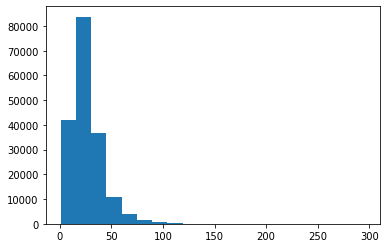

In [28]:
# Check distribution plot
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [29]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
max(sent_lens)

296

If we set the tensor dimension to 55 words, we will be able to 95% of the sentences. The maximum number of words in a sentence is 296 - insane.

In [31]:
# Vectorize text to prepare for deep sequence models
# Note that there are 20k words in our dataset. According to the paper, 
# the max vocab size in this instance is 68k. When dealing with the 200k
# words instance, the max vocab size is 331k

max_tokens = 68000
text_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = output_seq_len
)

In [32]:
text_vectorizer.adapt(train_sentences)

In [33]:
# Test text vectorizer on random sentences

import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
endoanchors were implanted in @ patients ( @ % ) at the time of an initial evar procedure ( primary arm ) and in @ patients with an existing endograft and proximal aortic neck complications ( revision arm ) .

Length of text: 40

Vectorized text: [[18831     9  3283     5    12    15     2    63     4    26   473  5844
    407    56   207     3     5    12     7    26  2113 23240     3  1844
   1085   932   296  4626   207     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words are there in the training volcabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


The least common words look like typos

In [35]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

In [36]:
#Create custom text embedding
token_embed = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True, #use masking to handle variable sequence lengths
    name = 'token_embedding'
)

In [37]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 endoanchors were implanted in @ patients ( @ % ) at the time of an initial evar procedure ( primary arm ) and in @ patients with an existing endograft and proximal aortic neck complications ( revision arm ) .

Sentence after vectorization (before embedding):
[[18831     9  3283     5    12    15     2    63     4    26   473  5844
    407    56   207     3     5    12     7    26  2113 23240     3  1844
   1085   932   296  4626   207     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.01998963 -0.00103444 -0.0271432  ...  0.00553035 -0.0168883
   -0.002477  ]
  [ 0.04325826  0.02633612  0.01518153 ... -0.04220957  0.01714362
   -0.00309465]
  [ 0.0174812  -0.03019207 -0.04970237 ...  0.03930148  0.0076776
   -0.02895091]
  ...
  [-0.00850794 -0.04879714  0.03172788 ... -0.01541727 -0.02367991
   -0.01871039]
  [-

Each word is embedded in a 128 dimension long feature vector. Each sentence has a max length of 55 words, padded by 0s if the sentence is too short.

### Creating a tensorflow dataset to expedite tensorflow processing using tf.data API.
* https://www.tensorflow.org/guide/data_performance


In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
#Turn tensordatasets into pre-fetched datasets

#The order of the dataset is important, so we do not use shuffle here
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [40]:
#Build model

inputs = layers.Input(shape=(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters = 32,
                  kernel_size = 5, #n-gram of 5 words at a time
                  activation = 'relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,
                       activation = 'softmax')(x)

model1 = tf.keras.Model(inputs, outputs)

#Compile
model1.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 51, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 165   

In [41]:
#Fit model
#There are 180k training datasets which might take awhile. We reduce the steps_per_epoch
#because this is the experiment phase - we want to know what doesn't work
history_model1 = model1.fit(train_dataset,
                            steps_per_epoch = int(0.1*len(train_dataset)), #speed up training by looking at only 10% of every epoch
                            epochs = 3,
                            validation_data = val_dataset,
                            validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 48ms/step - loss: 0.8990 - accuracy: 0.6626 - val_loss: 0.6242 - val_accuracy: 0.7756
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6012 - accuracy: 0.7797 - val_loss: 0.5584 - val_accuracy: 0.7852
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.5655 - accuracy: 0.7911 - val_loss: 0.5429 - val_accuracy: 0.7936


In [42]:
#Evaluate model on whole validation dataset
model1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5420 - accuracy: 0.7971


[0.5420020818710327, 0.7971004843711853]

In [43]:
#Make predictions 
model1_pred_probs = model1.predict(val_dataset)
model1_pred_probs, model1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[5.38435578e-01, 1.47545427e-01, 5.38138626e-03, 3.05529177e-01,
         3.10843578e-03],
        [3.25504929e-01, 5.58551788e-01, 7.51638261e-04, 1.12883516e-01,
         2.30815099e-03],
        [1.75569266e-01, 2.01506726e-02, 1.04352655e-02, 7.92103589e-01,
         1.74124481e-03],
        ...,
        [1.91246872e-04, 1.91157626e-03, 1.09351464e-02, 1.40446340e-04,
         9.86821592e-01],
        [2.13513356e-02, 3.46301019e-01, 7.09048659e-02, 8.97805393e-03,
         5.52464724e-01],
        [2.23743021e-02, 9.57566261e-01, 7.28507107e-03, 4.95674275e-03,
         7.81761948e-03]], dtype=float32), (30212, 5))

In [44]:
#Convert pred probs to classes
model1_preds = tf.argmax(model1_pred_probs, axis = 1)
model1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [45]:
model1_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model1_preds)
model1_results

{'accuracy': 79.71004898715742,
 'precision': 0.7945835363861964,
 'recall': 0.7971004898715742,
 'f1': 0.7948695191151351}

Our conv1D model is doing bettter than our baseline. That's great news!

## Model 2: Using a pretrained model

In [46]:
import tensorflow_hub as hub

#Prepare pre-trained embedding layer
#The paper uses GLoVE embeddings which is not as recent as tensorflow's
#universal sentence encoder available on tensorflow hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [47]:
sentence_encoder_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    input_shape = [], #Must be an empty list
    dtype = tf.string,
    trainable = False, #We're just using this as a feature extractor
    name = 'USE'
)

In [48]:
model2 = Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
], name = 'model2_USE')

model2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model2.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
history_model2 = model2.fit(train_dataset,
                            steps_per_epoch = int(0.1*len(train_dataset)), #speed up training by looking at only 10% of every epoch
                            epochs = 3,
                            validation_data = val_dataset,
                            validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 16ms/step - loss: 0.9173 - accuracy: 0.6514 - val_loss: 0.7966 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7700 - accuracy: 0.7011 - val_loss: 0.7559 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7556 - accuracy: 0.7101 - val_loss: 0.7416 - val_accuracy: 0.7148


In [50]:
model2_pred_probs = model2.predict(val_dataset)
model2_preds = tf.argmax(model2_pred_probs, axis = 1)
model2_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model2_preds)
model2_results

945/945 [==============================] - 11s 11ms/step


{'accuracy': 71.25645438898451,
 'precision': 0.7131498287804312,
 'recall': 0.7125645438898451,
 'f1': 0.7096894026429431}

This is to be expected because the pretrained model has fewer parameters and is therefore unable to capture as many variations as model 1.

## Model 3 - Conv1D character embeddings
The order of characters can be taken into account instead of just the order of words. We are essentially developing a feature vector for each character. We first vectorize our sequences (after they've been split into characters) using the TextVectorization class, and pass those sequences into an embedding layer.

In [51]:
def split_to_chars(text):
  return " ".join(list(text))

In [52]:
split_to_chars(target_sentence)

'e n d o a n c h o r s   w e r e   i m p l a n t e d   i n   @   p a t i e n t s   (   @   %   )   a t   t h e   t i m e   o f   a n   i n i t i a l   e v a r   p r o c e d u r e   (   p r i m a r y   a r m   )   a n d   i n   @   p a t i e n t s   w i t h   a n   e x i s t i n g   e n d o g r a f t   a n d   p r o x i m a l   a o r t i c   n e c k   c o m p l i c a t i o n s   (   r e v i s i o n   a r m   )   .'

In [53]:
train_chars = [split_to_chars(sentence) for sentence in train_sentences]
val_chars = [split_to_chars(sentence) for sentence in val_sentences]
test_chars = [split_to_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [54]:
#What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
print(f'Mean character length in sentences is {np.mean(char_lens)} characters')

Mean character length in sentences is 149.3662574983337 characters


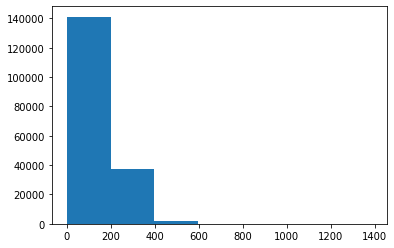

In [55]:
plt.hist(char_lens, bins = 7);

In [56]:
# Finding the 95th percentile
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

### Setup text vectorization layer
We need to set up the maximum character level tokens as our vocab. The vectorization layer maps characters to integers

In [57]:
# Shorcut to get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKENS = len(alphabet) +2 #Include space and OOV(out of vocab) token
alphabet, NUM_CHAR_TOKENS

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 70)

In [58]:
char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKENS,
    output_sequence_length = output_seq_char_len,
    standardize='lower_and_strip_punctuation',
    name = "char_vectorizer"
)

In [59]:
#Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [60]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common chars: {char_vocab[:5]}')
print(f'5 least common chars: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common chars: ['', '[UNK]', 'e', 't', 'i']
5 least common chars: ['k', 'x', 'z', 'q', 'j']


There are only 28 characters because the TextVectorization layer has a standardization argument that removes punctuation by default. We can set the standardization to None if we want to leave punctuation characters in.

In [61]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p r e m e n o p a u s a l   o r   p e r i m e n o p a u s a l   w o m e n   a l s o   r e c e i v e d   g o s e r e l i n   .

Length of chars: 56

Vectorized chars:
[[14  8  2 15  2  6  7 14  5 16  9  5 12  7  8 14  2  8  4 15  2  6  7 14
   5 16  9  5 12 20  7 15  2  6  5 12  9  7  8  2 11  2  4 21  2 10 18  7
   9  2  8  2 12  4  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0

### Creating character level embedding

In [62]:
#Create custom text embedding
char_embed = layers.Embedding(
    input_dim = NUM_CHAR_TOKENS,
    output_dim = len(char_vocab),
    mask_zero = False,# don't use masks (this messes up model5 if set to True)
    name = 'char_embed'
)

In [63]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p r e m e n o p a u s a l   o r   p e r i m e n o p a u s a l   w o m e n   a l s o   r e c e i v e d   g o s e r e l i n   .

Embedded chars (after vectorization and embedding):
[[[-0.04263892  0.0293391  -0.0377255  ... -0.04589968 -0.02296937
    0.00536485]
  [ 0.02853756 -0.04140062 -0.02940319 ... -0.03792388 -0.01689826
   -0.04436386]
  [-0.04821926  0.04953914  0.02988252 ... -0.02735244  0.034736
   -0.02776841]
  ...
  [-0.0425186  -0.01677253  0.00102396 ...  0.00126503  0.02793512
   -0.040652  ]
  [-0.0425186  -0.01677253  0.00102396 ...  0.00126503  0.02793512
   -0.040652  ]
  [-0.0425186  -0.01677253  0.00102396 ...  0.00126503  0.02793512
   -0.040652  ]]]

Character embedding shape: (1, 290, 28)


In [64]:
#Build model

inputs = layers.Input(shape=(1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5, #n-gram of 5 words at a time
                  padding = "same",
                  activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,
                       activation = 'softmax')(x)

model3 = tf.keras.Model(inputs, 
                        outputs,
                        name='model3_conv1d_char_embeddings')

#Compile
model3.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model3.summary()

Model: "model3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 28)           1960      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           9024      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5

In [65]:
#Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices(
    (train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices(
    (val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [66]:
history3 = model3.fit(train_char_dataset,
                      steps_per_epoch=int(0.1*len(train_char_dataset)),
                      epochs = 3,
                      validation_data = val_char_dataset,
                      validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2538 - accuracy: 0.4952 - val_loss: 1.0458 - val_accuracy: 0.5791
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 1.0030 - accuracy: 0.5998 - val_loss: 0.9420 - val_accuracy: 0.6213
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9301 - accuracy: 0.6333 - val_loss: 0.8771 - val_accuracy: 0.6589


In [67]:
model3_pred_probs = model3.predict(val_char_dataset)
model3_preds = tf.argmax(model3_pred_probs, axis = 1)
model3_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model3_preds)
model3_results

945/945 [==============================] - 3s 3ms/step


{'accuracy': 65.17277902820071,
 'precision': 0.6417086583575667,
 'recall': 0.6517277902820071,
 'f1': 0.642013564833251}

The results are unexpectedly poorer than the other experiments ran earlier. Oh well - some experiments just don't pan out.

## Model 4: Combining pretrained token embeddings and character embeddings.
1. Create a token-embedding model (similar to model1).
2. Create a character level model (similar to `model3` with a slight modification
3. Combine #1 & #2 with a concatenate (`layers.concatenate`)
4. Build a series of output layers on top of #3
5. Construct a model which takes token and character-level sequences as input and produces sequence labels as probabilities as output.
6. Developing `tf.data` datasets for model 4
7. Fit model 4.
8. Evaluate model 4

In [68]:
# 4.1. Setup token inputs/model

token_inputs = layers.Input(shape = [], #Expected by tf.hub
                            dtype = tf.string,
                            name = 'token_input')

sentence_embedding_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable = False,
    name = 'universal_sentence_encoder'
)

token_embeddings = sentence_embedding_layer(token_inputs)

token_outputs = layers.Dense(
    128,
    activation = 'relu')(token_embeddings)

token_model = tf.keras.Model(
    inputs = token_inputs,
    outputs = token_outputs
)

In [69]:
# 4.2 Setup char inputs/model
char_inputs = layers.Input(shape = (1,),
                           dtype = tf.string,
                           name = 'char_input')

char_vectors = char_vectorizer(char_inputs)

char_embeddings = char_embed(char_vectors)

#Bi-LSTM layers
char_bi_lstm = layers.Bidirectional(
    layers.LSTM(32)
)(char_embeddings) 

char_model = tf.keras.Model(
    inputs = char_inputs,
    outputs = char_bi_lstm
    )

In [70]:
# 4.3 Combine 4.1 and 4.2 using concatenate
sentence_char_concat = layers.Concatenate(name = 'token_char_hybrid')(
    [token_model.output, char_model.output])

In [71]:
# 4.4 Create output layers - adding in Dropout

combined_dropout = layers.Dropout(0.5)(sentence_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,
                            activation='softmax')(final_dropout)

In [72]:
#4.5 Construct combined model
model4 = tf.keras.Model(
    inputs = [token_model.input, char_model.input],
    outputs = output_layer,
    name = 'model4_sentence_and_char_embeddings'
)

model4.summary()

Model: "model4_sentence_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824  

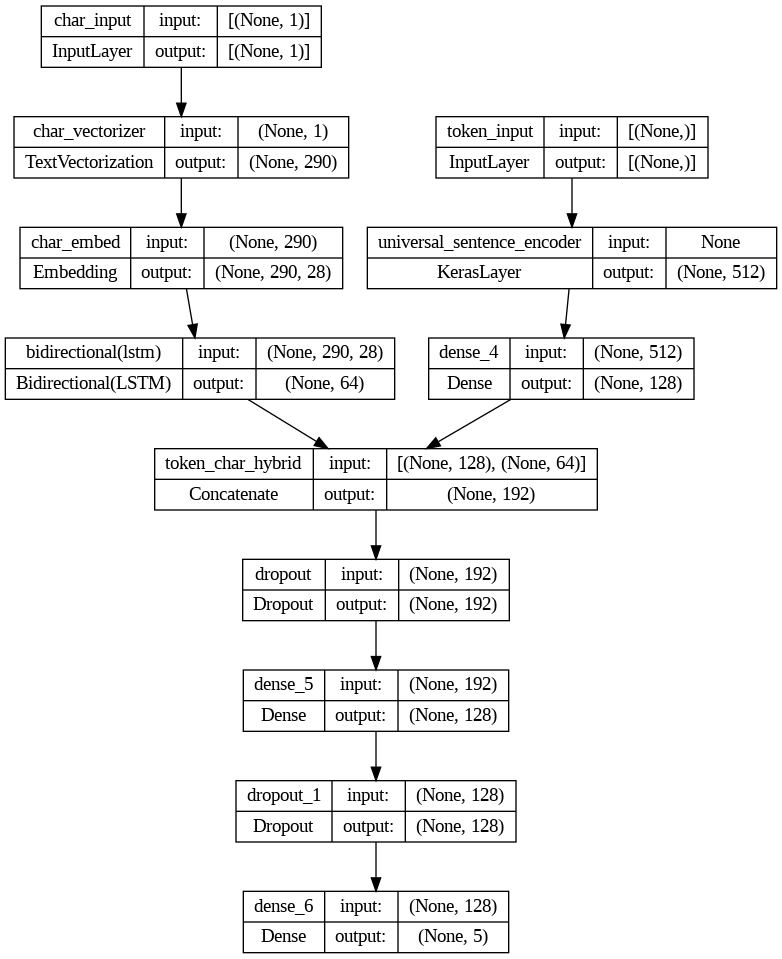

In [73]:
from keras.utils import plot_model
plot_model(model4, show_shapes = True)

In [74]:
model4.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [75]:
# Develop training dataset for model 4

#Train dataset
train_sentence_char_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars))
train_sentence_char_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot
)
train_char_token_dataset = tf.data.Dataset.zip((
    train_sentence_char_dataset,
    train_sentence_char_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

#Validation dataset
val_sentence_char_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars))
val_sentence_char_labels = tf.data.Dataset.from_tensor_slices(
    val_labels_one_hot
)
val_char_token_dataset = tf.data.Dataset.zip((
    val_sentence_char_dataset,
    val_sentence_char_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [77]:
# 4.7 Fit model to dataset
history4 = model4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    epochs=3,
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1*len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 29s 35ms/step - loss: 0.9865 - accuracy: 0.6054 - val_loss: 0.7947 - val_accuracy: 0.6932
Epoch 2/3
562/562 [==============================] - 19s 35ms/step - loss: 0.8077 - accuracy: 0.6878 - val_loss: 0.7193 - val_accuracy: 0.7330
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7769 - accuracy: 0.7055 - val_loss: 0.7037 - val_accuracy: 0.7377


In [78]:
# 4.8 Model evaluation
model4_pred_probs = model4.predict(val_char_token_dataset)
model4_preds = tf.argmax(model4_pred_probs, axis = 1)
model4_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model4_preds)
model4_results

945/945 [==============================] - 18s 17ms/step


{'accuracy': 73.11333245068184,
 'precision': 0.7334886234574849,
 'recall': 0.7311333245068184,
 'f1': 0.7293988848535262}

Model 4 still doesn't perform very well. It is likely that the model's accuracy is negatively impacted by the character learning portion of the model. Model 1 is still the best performing model

## Model 5: Adding positional embeddings to model 4
The paper also experimented with a label sequence optimization layer. The authors found that the order of sequence of how sentences appear also matters - i.e. the first sentence of the summary is most likely going to belong to the **objective** segment of the paper. Let's try this out! 

This means we have more preprocessing to do. Broadly, the steps are:
1. Create a position embedding model for `line_number` and `total_lines` features. Remember we added the line number when we created the dictionary of sentences - we can use this to develop position embeddings.
2. Combine #1 with the sentence embedding and character embedding models in 4.1 and 4.2 using `layers.concatenate`
3. Build a series of output layers on top of #2
4. Construct a model which takes token and character-level sequences as input and produces sequence labels as probabilities as output.
5. Developing `tf.data` datasets for model 5
6. Fit model 5
7. Evaluate model 5

### 5.1 Creating a position embedding model

In [79]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

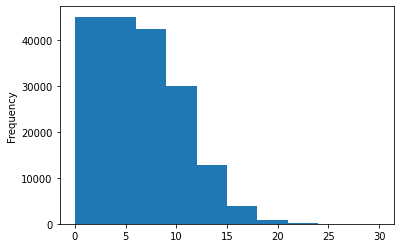

In [80]:
train_df.line_number.plot.hist()

We're going to one-hot encode the line number column, but it's not necessary to one-hot encode the entire value set because there are very few samples with a summary reaching 30 lines. Restricting the one-hot encode to a line value of 15 is sufficient.

We'll use Tensorflow's one-hot encoding tool this time

In [81]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),
                                        depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),
                                      depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),
                                       depth = 15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

We'll need to do the same thing for 'total lines'.

In [82]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

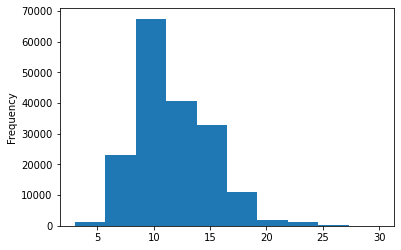

In [83]:
train_df.total_lines.plot.hist()

In [84]:
#Check 95th percentile
np.percentile(train_df.total_lines, 95)

18.0

20 is a good cutoff

In [85]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),
                                        depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),
                                     depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),
                                      depth = 20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [86]:
# Token model
token_inputs = layers.Input(shape=[],
                            dtype="string",
                            name="token_inputs")
token_embeddings = sentence_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

# Char model
char_inputs = layers.Input(shape=(1,),
                           dtype="string",
                           name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(
    layers.LSTM(32)
)(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# line_numbers position encoding model
line_number_inputs = layers.Input(
    shape = (15,), #matches the depth
    dtype = tf.int32,
    name = 'line_number_input'
)
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# total_line_numbers position enocding model
total_line_inputs = layers.Input(
    shape = (20,),
    dtype = tf.int32,
    name = 'total_line_inputs'
)
y = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs = total_line_inputs,
                                  outputs = y)

### 5.2 - 5.4

In [87]:
combined_embeddings = layers.Concatenate(
    name="token_char_hybrid_embedding"
    )([token_model.output, char_model.output])

# We follow the paper and first pass the sentence embeddings through a dropout
z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z) #following the paper

# Combine z with position embeddings
tribrid_embeddings = layers.Concatenate(
    name = 'char_token_position_embedding'
)([line_number_model.output,
   total_line_model.output,
   z])

output_layer = layers.Dense(
    5,
    activation = 'softmax',
    name = 'output_layer'
)(tribrid_embeddings)


#Note the order of inputs - this is important
model5 = tf.keras.Model(inputs = [line_number_model.input,
                                  total_line_model.input,
                                  token_model.input,
                                  char_model.input],
                        outputs = output_layer,
                        name = 'model5_tribrid_model')

model5.summary()

Model: "model5_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs

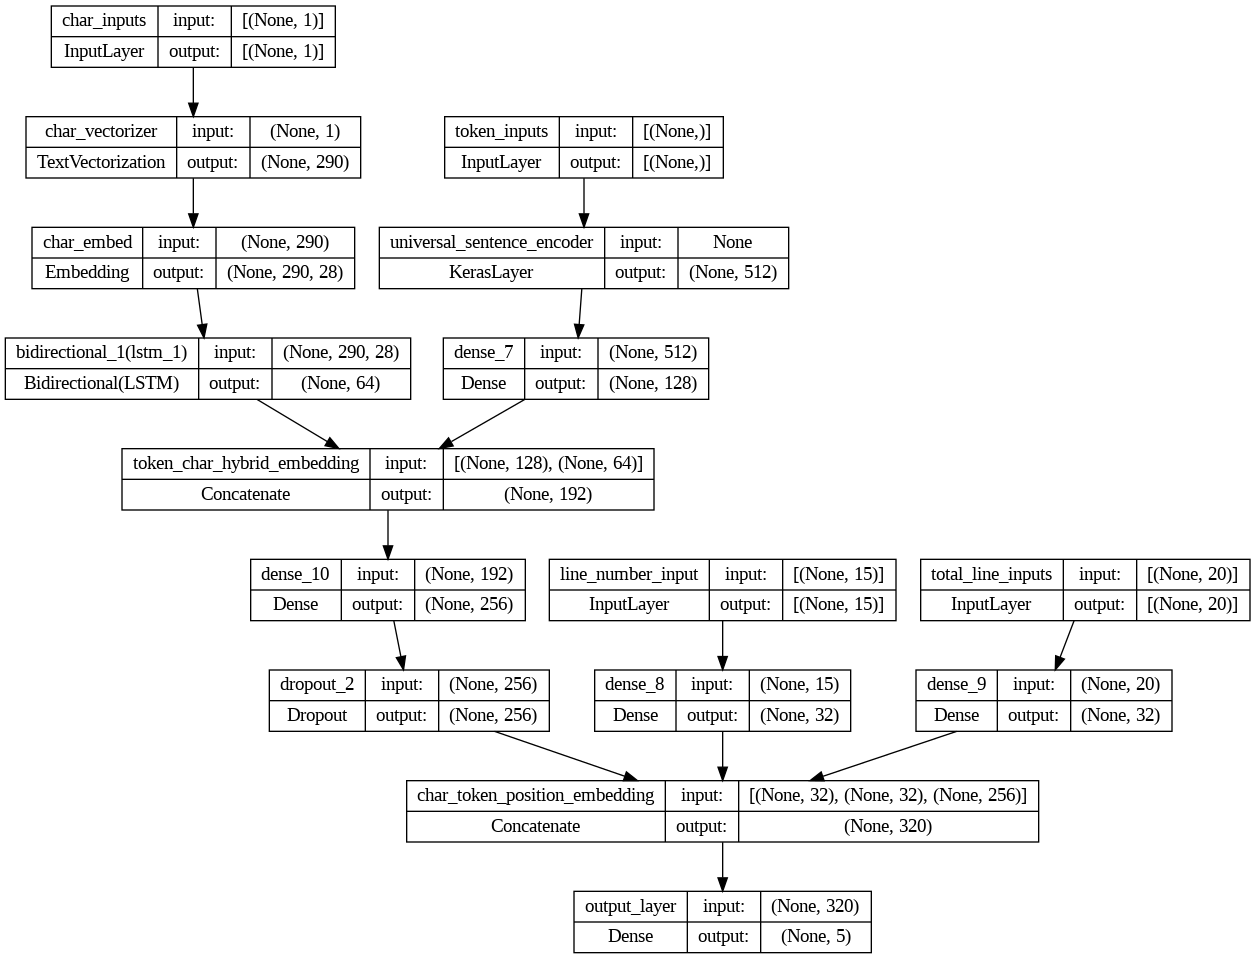

In [88]:
plot_model(model5, show_shapes = True)

If our model gets too confident ona. single class, it may get stuck on that class and not consider other classes. Label smoothing assigns some of the value from the highest prediction probability to other classes in turn to improve generalization.

> According to tensorflow.org (https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)

When > 0, label values are smoothed, meaning the confidence on label values are relaxed. For example, if 0.1, use 0.1 / num_classes for non-target labels and 0.9 + 0.1 / num_classes for target labels.

> Also check out this article: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/


In [89]:
# Compile token, char and positional embedding model

model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### 5.5 Let's create the training and validation datasets using tf.data to optimize dataloading pipeline

In [90]:
# Create training and validation dataset with all 4 kinds of input data
tribrid_train_data = tf.data.Dataset.from_tensor_slices(
    (train_line_numbers_one_hot,
     train_total_lines_one_hot,
     train_sentences,
     train_chars))

tribrid_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

# Zipping it all together
tribrid_train = tf.data.Dataset.zip(
    (tribrid_train_data, tribrid_train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Val data
tribrid_val_data = tf.data.Dataset.from_tensor_slices(
    (val_line_numbers_one_hot,
     val_total_lines_one_hot,
     val_sentences,
     val_chars))

tribrid_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

tribrid_val = tf.data.Dataset.zip(
    (tribrid_val_data, tribrid_val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
tribrid_train, tribrid_val

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### 5.6 and 5.7: Fit and evaluate the model

In [92]:
history5 = model5.fit(
    tribrid_train,
    steps_per_epoch=int(0.1*len(tribrid_train)),
    epochs=3,
    validation_data = tribrid_val,
    validation_steps = int(0.1*len(tribrid_val))
)

Epoch 1/3
562/562 [==============================] - 27s 36ms/step - loss: 1.0933 - accuracy: 0.7259 - val_loss: 0.9800 - val_accuracy: 0.8082
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9674 - accuracy: 0.8133 - val_loss: 0.9512 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 21s 38ms/step - loss: 0.9530 - accuracy: 0.8200 - val_loss: 0.9404 - val_accuracy: 0.8268


In [93]:
model5_pred_probs = model5.predict(tribrid_val)
model5_preds = tf.argmax(model5_pred_probs, axis = 1)
model5_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model5_preds)
model5_results

945/945 [==============================] - 18s 18ms/step


{'accuracy': 83.0266119422746,
 'precision': 0.8290728430261586,
 'recall': 0.830266119422746,
 'f1': 0.8294208919356248}

And this is our best model so far! Positional embeddings are a game changer here, and quite possibly the most important feature in this application.

## Comparing all our model results

In [94]:
all_model_results = pd.DataFrame({
    'model0_baseline': baseline_results,
    'model1_custom_token_embedding': model1_results,
    'model2_pretrained_token_embedding': model2_results,
    'model3_custom_char_embedding': model3_results,
    'model4_char_token_embeddings': model4_results,
    'model5_pos_char_token_embedding': model5_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model0_baseline,72.183238,0.718647,0.721832,0.698925
model1_custom_token_embedding,79.710049,0.794584,0.797100,0.794870
model2_pretrained_token_embedding,71.256454,0.713150,0.712565,0.709689
model3_custom_char_embedding,65.172779,0.641709,0.651728,0.642014
model4_char_token_embeddings,73.113332,0.733489,0.731133,0.729399
model5_pos_char_token_embedding,83.026612,0.829073,0.830266,0.829421


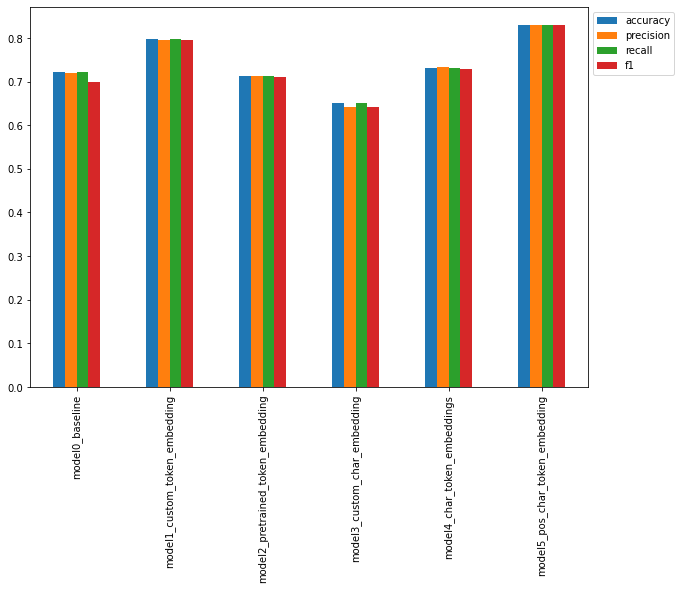

In [95]:
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results.plot(
    kind = 'bar',
    figsize = (10,7),
).legend(bbox_to_anchor=(1.0, 1.0));

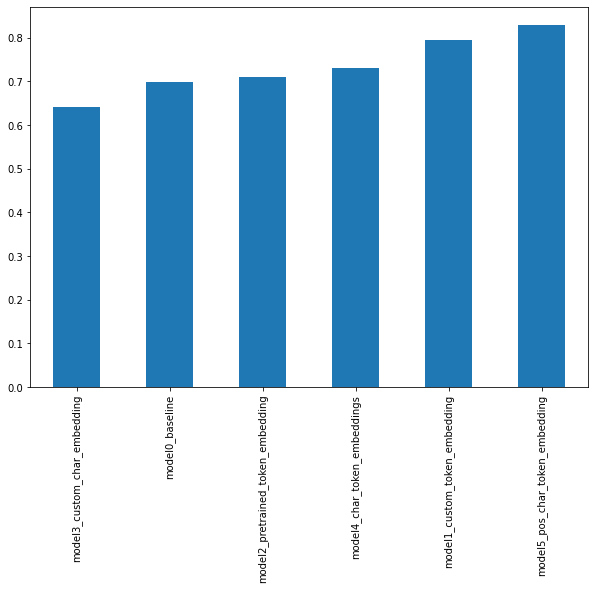

In [96]:
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10,7));

## Train model 5 on entire training dataset

In [99]:
model6 = tf.keras.models.clone_model(model5)
model6.summary()

Model: "model5_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs

In [102]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 verbose=1)

In [103]:
model6 = tf.keras.Model(inputs = [line_number_model.input,
                                  total_line_model.input,
                                  token_model.input,
                                  char_model.input],
                        outputs = output_layer,
                        name = 'model6_tribrid_model')

model6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

history6 = model6.fit(
    tribrid_train,
    epochs=5, #train for more epochs
    validation_data = tribrid_val,
    validation_steps = int(0.1*len(tribrid_val)),
    callbacks=[cp_callback]
)

Epoch 1/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.8924 - accuracy: 0.8660
Epoch 1: saving model to training/cp.ckpt
5627/5627 [==============================] - 188s 32ms/step - loss: 0.8924 - accuracy: 0.8660 - val_loss: 0.8977 - val_accuracy: 0.8521
Epoch 2/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.8850 - accuracy: 0.8724
Epoch 2: saving model to training/cp.ckpt
5627/5627 [==============================] - 175s 31ms/step - loss: 0.8850 - accuracy: 0.8724 - val_loss: 0.8996 - val_accuracy: 0.8524
Epoch 3/5
5627/5627 [==============================] - ETA: 0s - loss: 0.8789 - accuracy: 0.8767
Epoch 3: saving model to training/cp.ckpt
5627/5627 [==============================] - 178s 32ms/step - loss: 0.8789 - accuracy: 0.8767 - val_loss: 0.8998 - val_accuracy: 0.8511
Epoch 4/5
5627/5627 [==============================] - ETA: 0s - loss: 0.8731 - accuracy: 0.8806
Epoch 4: saving model to training/cp.ckpt
5627/5627 [=========================

In [104]:
model6_pred_probs = model6.predict(tribrid_val)
model6_preds = tf.argmax(model6_pred_probs, axis = 1)
model6_results = calculate_results(y_true = val_labels_encoded,
                                   y_pred = model6_preds)
model6_results

945/945 [==============================] - 18s 18ms/step


{'accuracy': 85.19793459552496,
 'precision': 0.8543263286467527,
 'recall': 0.8519793459552496,
 'f1': 0.8497476499624699}

## Save and load model for testing

In [105]:
def build_model():
  # Token model
  token_inputs = layers.Input(shape=[],
                              dtype="string",
                              name="token_inputs")
  token_embeddings = sentence_embedding_layer(token_inputs)
  token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
  token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

  # Char model
  char_inputs = layers.Input(shape=(1,),
                            dtype="string",
                            name="char_inputs")
  char_vectors = char_vectorizer(char_inputs)
  char_embeddings = char_embed(char_vectors)
  char_bi_lstm = layers.Bidirectional(
      layers.LSTM(32)
  )(char_embeddings)
  char_model = tf.keras.Model(inputs = char_inputs,
                              outputs = char_bi_lstm)

  # line_numbers position encoding model
  line_number_inputs = layers.Input(
      shape = (15,), #matches the depth
      dtype = tf.int32,
      name = 'line_number_input'
  )
  x = layers.Dense(32, activation='relu')(line_number_inputs)
  line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                    outputs = x)

  # total_line_numbers position enocding model
  total_line_inputs = layers.Input(
      shape = (20,),
      dtype = tf.int32,
      name = 'total_line_inputs'
  )
  y = layers.Dense(32, activation='relu')(total_line_inputs)
  total_line_model = tf.keras.Model(inputs = total_line_inputs,
                                    outputs = y)
  
  combined_embeddings = layers.Concatenate(
    name="token_char_hybrid_embedding"
    )([token_model.output, char_model.output])

  # Sentence embeddings are passed through a dropout
  z = layers.Dense(256, activation = 'relu')(combined_embeddings)
  z = layers.Dropout(0.5)(z) #following the paper

  # Combine z with position embeddings
  tribrid_embeddings = layers.Concatenate(
      name = 'char_token_position_embedding'
  )([line_number_model.output,
    total_line_model.output,
    z])

  output_layer = layers.Dense(
      5,
      activation = 'softmax',
      name = 'output_layer'
  )(tribrid_embeddings)

  model = tf.keras.Model(inputs = [line_number_model.input,
                                  total_line_model.input,
                                  token_model.input,
                                  char_model.input],
                        outputs = output_layer,
                        name = 'model_tribrid_model')
  
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
      )

  return model

In [106]:
model = build_model()
model.summary()

Model: "model_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[

In [107]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training/cp.ckpt'

In [108]:
model.load_weights(latest)

In [109]:
model.evaluate(tribrid_val)

945/945 [==============================] - 22s 21ms/step - loss: 0.9012 - accuracy: 0.8520


[0.9011713862419128, 0.8519793748855591]

In [110]:
!zip -r /content/model_weights.zip /content/training

  adding: content/training/ (stored 0%)
  adding: content/training/cp.ckpt.data-00000-of-00001 (deflated 7%)
  adding: content/training/cp.ckpt.index (deflated 77%)
  adding: content/training/checkpoint (deflated 38%)


In [111]:
from google.colab import files
files.download('model_weights.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [120]:
files.download('model.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model evaluation on a test dataset

Here's a reminder of all the test datasets we've defined thus far. Let's create the test dataset for model evaluation.

```
test_samples = preprocess_text(data_dir+'/test.txt')
test_df = pd.DataFrame(test_samples)

test_labels_encoded = label_encoder.transform(
    test_df['target'].to_numpy()
)
test_labels_one_hot = one_hot_encoder.transform(
    test_df['target'].to_numpy().reshape(-1,1)
)

test_sentences = test_df['text'].tolist()
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars = [split_to_chars(sentence) for sentence in test_sentences]
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),
                                       depth = 15)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),
                                      depth = 20)
````

In [112]:
tribrid_test_data = tf.data.Dataset.from_tensor_slices(
    (test_line_numbers_one_hot,
     test_total_lines_one_hot,
     test_sentences,
     test_chars))

tribrid_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

# Zipping it all together
tribrid_test = tf.data.Dataset.zip(
    (tribrid_test_data, tribrid_test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [113]:
model.evaluate(tribrid_test)

942/942 [==============================] - 20s 22ms/step - loss: 0.9099 - accuracy: 0.8481


[0.9098861217498779, 0.8480504155158997]

## Find the most wrong predictions - predictions with the highest prediction probability

In [114]:
test_pred_probs = model.predict(tribrid_test)
test_preds = tf.argmax(test_pred_probs, axis = 1)
test_preds[:10]

942/942 [==============================] - 23s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [115]:
model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_test_results

{'accuracy': 84.80504396880704,
 'precision': 0.8489286069355882,
 'recall': 0.8480504396880704,
 'f1': 0.8456423524117481}

In [116]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:5]

['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'RESULTS']

In [117]:
test_df['prediction'] = test_pred_classes
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis = 1).numpy()
test_df['correct'] = test_df['prediction'] == test_df['target']
test_df.head(20)

,line_number,target,text,total_lines,prediction,pred_prob,correct
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8,OBJECTIVE,0.401908,False
1,1,RESULTS,a post hoc analysis was conducted with the use...,8,METHODS,0.503287,False
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8,METHODS,0.852952,False
3,3,RESULTS,survival analyses were used to assess the asso...,8,METHODS,0.786151,False
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8,RESULTS,0.808469,True
5,5,RESULTS,when mean hemodynamic profiles were compared i...,8,RESULTS,0.891641,True
6,6,RESULTS,multivariable analyses revealed that patients ...,8,RESULTS,0.885331,True
7,7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,8,CONCLUSIONS,0.682938,True
8,8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,CONCLUSIONS,0.775527,True
9,0,BACKGROUND,minimally invasive endovascular aneurysm repai...,12,BACKGROUND,0.652344,True


In [118]:
top100_wrong = test_df[test_df['correct'] == False].sort_values("pred_prob", 
                                                                ascending=False
                                                                )[:100]
top100_wrong.head(5)

,line_number,target,text,total_lines,prediction,pred_prob,correct
8545,1,METHODS,pretest-posttest .,11,BACKGROUND,0.968793,False
19223,7,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",10,RESULTS,0.952176,False
16780,16,METHODS,we will comply with the consort guidelines and...,19,BACKGROUND,0.943906,False
1827,18,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,BACKGROUND,0.942076,False
6955,0,OBJECTIVE,many people consume alcoholic beverages follow...,18,BACKGROUND,0.938732,False


In [119]:
for row in top100_wrong[0:5].itertuples():
  _, line_number, target, text, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Prediction: {prediction}, Probability: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: METHODS, Prediction: BACKGROUND, Probability: 0.9687930941581726, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: METHODS, Prediction: RESULTS, Probability: 0.9521756172180176, Line number: 7, Total lines: 10

Text:
of the @ dogs receiving placebo , @ ( @ % ) vomited and @ ( @ % ) developed signs of nausea ; overall , @ of @ ( @ % ) dogs in the placebo treatment group vomited or developed signs of nausea .

-----

Target: METHODS, Prediction: BACKGROUND, Probability: 0.9439062476158142, Line number: 16, Total lines: 19

Text:
we will comply with the consort guidelines and will disseminate the findings at national and international conferences and in peer-reviewed journals .

-----

Target: CONCLUSIONS, Prediction: BACKGROUND, Probability: 0.9420761466026306, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: OBJECTIVE, Prediction: BACKGROUND, Probability: 0.9387317299842834, Line number: 0, Total lines: 18

Text:
many

## Testing the model against datasets from the wild

In [121]:
import json

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-03-05 03:32:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-03-05 03:32:27 (80.4 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [122]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [127]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English

nlp = English() # setup English sentence parser
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [128]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [129]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [130]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [132]:
# Split abstract lines into characters
abstract_chars = [split_to_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [134]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = model.predict(x=(test_abstract_line_numbers_one_hot,
                                            test_abstract_total_lines_one_hot,
                                            tf.constant(abstract_lines),
                                            tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step
CPU times: user 1.96 s, sys: 26.9 ms, total: 1.99 s
Wall time: 2.09 s


array([[0.3539962 , 0.09886955, 0.05459634, 0.45247555, 0.04006235],
       [0.09687404, 0.04400753, 0.69923455, 0.11033773, 0.04954607],
       [0.05452731, 0.02529541, 0.8165025 , 0.06141916, 0.0422556 ],
       [0.08474278, 0.16555925, 0.5567454 , 0.07625996, 0.11669263],
       [0.05405024, 0.08814576, 0.20546225, 0.04507188, 0.6072698 ],
       [0.03094934, 0.06092443, 0.612075  , 0.04105238, 0.25499886],
       [0.01478845, 0.04355629, 0.02826444, 0.02272507, 0.89066577],
       [0.01028181, 0.06543637, 0.038164  , 0.0171633 , 0.86895454]],
      dtype=float32)

In [135]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
                                
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
